# Neural Networks for Image De-noising
- Understand how multi-layer neural networks function.
- Build a multi layer perceptron that can analyze and deconvolve step functions

## Theory

Assume the noisy image can be written as a matrix $P_{i}$ where each element represents the pixel intensity of the $i$ th pixel. The goal is to train a neural network $f(P; K)$ where $K$ is the known convolution kernel to output a denoised image $Q_{i} = f(P; K)$. The nodes between the inputs and the outputs are the 'hidden nodes'. All nodes have a value between 0 and 1.

The node $a^{(1)}_0$ will have its value computed from a sum of the weighted inputs from the first layer.

$$a^{(1)}_0 = \sigma(b_0+\sum_{i} w_{i}P_{i})$$

Where $\sigma$ is the normalisation function given by $\sigma(x) = \frac{1}{1 + e^{-x}}$. $w_{i}$ are the weights associated with each input pixel $P_{i}$, $b_0$ is the bias term.

The first next layer of hidden nodes can be calculated from:

$$\mathbf{a}^{(i+1)} = \sigma(W^{(i)}\mathbf{a}^{(i)} + \mathbf{b}^{(i)})$$
 
Where $W^{(i)}$ is the weight matrix and $\mathbf{b}^{(i)}$ is the bias vector which transforms the $i$ th layer into the $i+1$ th layer. The values of $W^{(i)}$ and $\mathbf{b}^{(i)}$ are learned during training.

## Gradient Descent

The cost function measures the success of the machine learning algorithm one way it could be defined is as follows:

$$C(\mathbf{w}) = \sum_i (\hat{p}_i - p_i)^2$$

Where $\hat{p}_i$ is the estimated state from the MLP and $p_i$ is the known state. The vector $\mathbf{w}$ contains all the weights in the network. This sum is small when the network is close to being "correct".

Using gradient decent can be used to find a local minima, an optimized solution. The vector $-\Delta C(\mathbf{w})$ points in the direction of steepest decent.


## Generate test data

In [1]:
import torch
import matplotlib.pyplot as plt
from ImageDebluring import *
from sklearn.preprocessing import MinMaxScaler

def step_function(period=2.0, amplitude=0.8, y_intercept=0.0, steps=1000, x_offset=0.0):
    s = steps
    xs = torch.linspace(-5, 5, steps=s)
    ys = amplitude * torch.heaviside(torch.sin(2 * torch.pi * (xs + x_offset) / period), torch.zeros_like(xs)) + y_intercept
    return ys

def generate_random_function(vary_period = False, vary_amplitude = False, vary_y_intercept = False, vary_x_offset = False, rng = None):
    if vary_period:
        period = torch.rand(1, generator=rng).item()*3 + 5
    else:
        period = 5
    if vary_amplitude:
        amplitude = torch.rand(1, generator=rng).item() * 0.9 + 0.1
    else:
        amplitude = 0.3
    if vary_y_intercept:
        y_intercept = torch.rand(1, generator=rng).item() * 0.3
    else:
        y_intercept = 0.3
    if vary_x_offset:
        x_offset = torch.rand(1, generator=rng).item() * 2*torch.pi
    else:
        x_offset = 0.0
    return step_function(period, amplitude, y_intercept, x_offset=x_offset).unsqueeze(0).unsqueeze(0)

def generate_test_data(amount = 10000, noise_scale = 5000, blur_std = 61, kernel_size=20, vary_period = False, vary_amplitude = False, vary_y_intercept = False, vary_x_offset = False, rng = None, seed = None):
    if rng is None and seed is not None:
        rng = torch.Generator().manual_seed(seed)
    y = []
    y_scalers = []
    X = []
    X_scalers = []
    for i in range (amount):
        data = generate_random_function(vary_period = vary_period, vary_amplitude = vary_amplitude, vary_y_intercept = vary_y_intercept, vary_x_offset = vary_x_offset, rng = rng)
        degraded_data = degrade_image_1D(data, noise_scale=noise_scale, kernel=gaussian_normalised_kernel_1D(blur_std, kernel_size), padding_mode='replicate')
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        # reshape to 2D (n_samples, n_features) for sklearn, then back to 1D
        degraded_np = degraded_data.squeeze().numpy().reshape(-1, 1)
        data_np = data.squeeze().numpy().reshape(-1, 1)
        degraded_scaled = scaler_x.fit_transform(degraded_np).reshape(-1)
        data_scaled = scaler_y.fit_transform(data_np).reshape(-1)
        degraded_data = torch.tensor(degraded_scaled, dtype=torch.float32)
        data = torch.tensor(data_scaled, dtype=torch.float32)
        X_scalers.append(scaler_x)
        y_scalers.append(scaler_y)
        X.append(degraded_data.squeeze())
        y.append(data.squeeze())
        
    # Make tensors
    X = torch.stack(X)
    y = torch.stack(y)
    
    return X, y, X_scalers, y_scalers

ModuleNotFoundError: No module named 'torch'

## Defining the MLP model
- input size for this dataset is 1000 (number of points in the 1D signal)
- hidden size can be adjusted, start with 128
- output size is also 1000 (number of points in the 1D signal)
- requires_grad=True to enable backpropagation

## Forward Pass
- Linear transformation of inputs $z^{(1)} = XW^{(1)} + b^{(1)}$
- Apply activation function $a^{(1)} = \sigma(z^{(1)})$ to node values
- Linear transformation of hidden layer $z^{(2)} = a^{(1)}W^{(2)} + b^{(2)}$
- Apply activation function $a^{(2)} = \sigma(z^{(2)})$ to get final output

## Backpropagation
- `backward` updates the weights and the baises
- `epochs` the number of times the model sees the entire dataset
- `lr` hyperparameter that controls the step size for weighted updates
- `loss` the MSE


In [49]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, rng = None):
        self.rng = rng
        self.W1 = torch.randn(input_size, hidden_size, requires_grad=True, generator=self.rng)
        self.b1 = torch.randn(1, hidden_size, requires_grad=True, generator=self.rng)
        self.W2 = torch.randn(hidden_size, output_size, requires_grad=True, generator=self.rng)
        self.b2 = torch.randn(1, output_size, requires_grad=True, generator=self.rng)

    def forward(self, X):
        self.z1 = torch.matmul(X, self.W1) + self.b1
        self.a1 = torch.sigmoid(self.z1) # applies sigmoid activation function
        self.z2 = torch.matmul(self.a1, self.W2) + self.b2
        self.a2 = torch.sigmoid(self.z2) 
        return self.a2
    
    def backward(self,X,y,output,lr=0.01):
        m = X.shape[0]
        dz2 = output - y
        dW2 = torch.matmul(self.a1.T, dz2)
        db2 = torch.sum(dz2, axis=0)/m
        
        da1 = torch.matmul(dz2, self.W2.T)
        dz1 = da1*(self.a1*(1-self.a1))
        dW1=torch.matmul(X.T,dz1)/m
        db1 = torch.sum(dz1, axis=0) / m
        
        with torch.no_grad():
            self.W1 -= lr * dW1
            self.b1 -= lr * db1
            self.W2 -= lr * dW2
            self.b2 -= lr * db2
            
    def train(self, X, y, epochs = 1000, lr = 0.01):
        losses = []
        print("\nlosses")
        for i in range(epochs):
            output = self.forward(X)
            # Compute loss using MSE
            loss = torch.mean((output - y)**2)
            losses.append(loss.item())
            # Update weights
            self.backward(X, y, output, lr)
            
            print(f'\rEpoch {i}, Loss: {loss.item()}', end='', flush=True)
        return losses
        

## Initialize model

In [50]:
def plot_losses(losses):
    fig, ax = plt.subplots()
    ax.scatter(range(len(losses)),  losses)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

def train_model(X_train_scaled, y_train_scaled, hidden_size = 128, epochs = 100, lr = 0.01, rng = None):
    input_size = X_train_scaled.shape[1]
    model = MLP(input_size, hidden_size, input_size, rng = rng)
    losses = model.train(X_train_scaled, y_train_scaled, epochs=epochs, lr=lr)
    plot_losses(losses)
    return model

## Testing
- `amount` is the number of waves that are generated for training and testing
- `noise_scale` is the scale factor for the signal before poisson noise is added
- `blur_std` is the standard devation of the guassian being convolved with the signal
- `kernel_size` is the size of the guassian being convolved with teh signal
- `epochs` is the number of iterations that the machine learning algorithm will train for
- `lr` is the hyperparameter that controls the step size for weighted updates
- `hidden_size` the number of hidden nodes in the MLP
- `vary_period/amplitude/y_intercept/x_offset` boolean describes if these should be variables when generating the waves.
- `X/y` an optional parameter which if not provided the programme will generate its own data
- `X/y-scalers` scalers so data can be unscaled after running through the machine learning algorithm

In [54]:
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

def test_model(amount = 10000, noise_scale = 5000, blur_std = 61, kernel_size=20, epochs=100, lr=0.01, hidden_size=128, vary_period=False, vary_amplitude=False, vary_y_intercept=False, vary_x_offset=False, X = None, y = None, seed_data = 42, seed_model = 42, X_scalers = None, y_scalers = None):
    if X is not None and y is not None:
        X_scaled = X
        y_scaled = y
    rng_data = torch.Generator().manual_seed(seed_data)
    rng_model = torch.Generator().manual_seed(seed_model)
    if X is None or y is None:
        print("Generating data...", end='', flush=True)
        X_scaled, y_scaled, X_scalers, y_scalers = generate_test_data(amount = amount, noise_scale = noise_scale, blur_std = blur_std, kernel_size=kernel_size, vary_period = vary_period, vary_amplitude = vary_amplitude, vary_y_intercept = vary_y_intercept, vary_x_offset = vary_x_offset, rng = rng_data)
        print("\nData generated", end='', flush=True)
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
    print("\nData preppared", end='', flush=True)
    model = train_model(X_train_scaled, y_train_scaled, epochs = epochs, lr = lr, hidden_size = hidden_size, rng = rng_model)
    print("\nModel trained", end='', flush=True)
    y_pred_scaled = model.forward(X_test_scaled)
    
    # Select 4 waves to vosialise
    fig, axs = plt.subplots(2,2, figsize=(8,8), sharex = True, sharey=True)
    axs = axs.flatten()

    for i in range (4):
        y_pred = y_scalers[i].inverse_transform(y_pred_scaled[i].detach().numpy().reshape(-1,1)).flatten()
        X_test = X_scalers[i].inverse_transform(X_test_scaled[i].detach().numpy().reshape(-1,1)).flatten()
        y_test = y_scalers[i].inverse_transform(y_test_scaled[i].detach().numpy().reshape(-1,1)).flatten()
        sns.lineplot(x=np.arange(len(y_pred)), y=y_pred, ax=axs[i], label='predicted', alpha = 0.7)
        sns.lineplot(x=np.arange(len(X_test)), y=X_test, ax=axs[i], label='degraded', alpha = 0.7)
        sns.lineplot(x=np.arange(len(y_test)), y=y_test, ax=axs[i], label='original', alpha = 0.7)
        axs[i].legend()
    print("\nDone!")

## Simplest model
- Simple model where the parameters defining the square wave are the same for each iteration
- the only thing that changes is the noise that is added to the square waves each time

Generating data...
Data generated
Data preppared
losses
Epoch 9, Loss: 3.0431750869253094e-11
Model trained
Done!


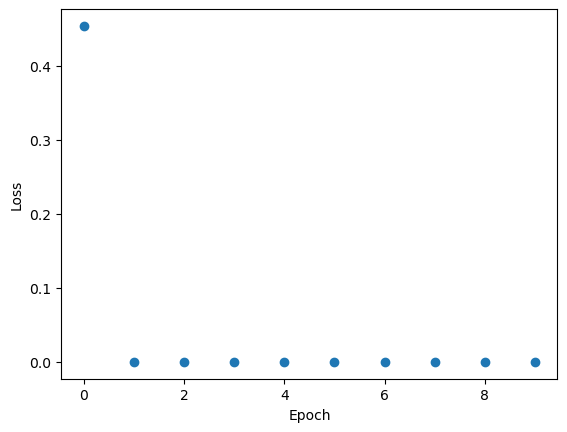

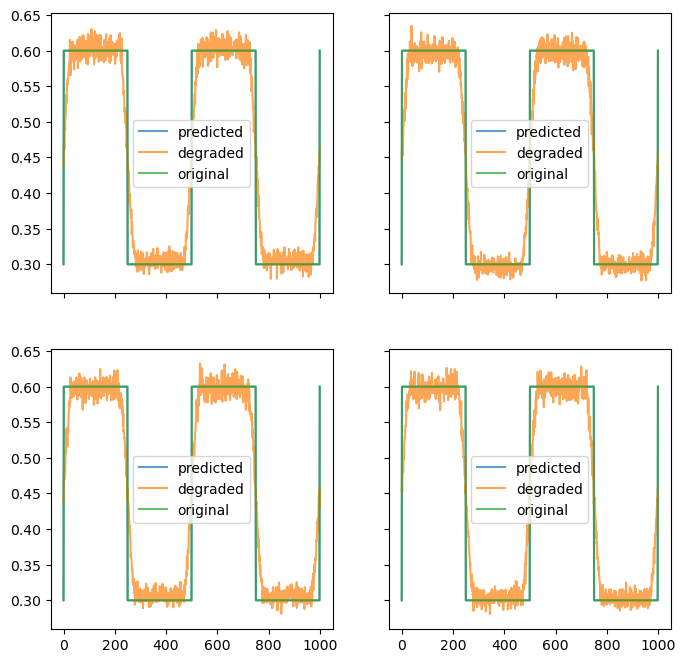

In [55]:
test_model(epochs=10)

- Converges very quickly
- the predicted waves are identical to the square waves
## Varying the x offset
- now also varying the x offset which is generated randomly


Data preppared
losses
Epoch 29, Loss: 0.32221731543540955
Model trained
Done!


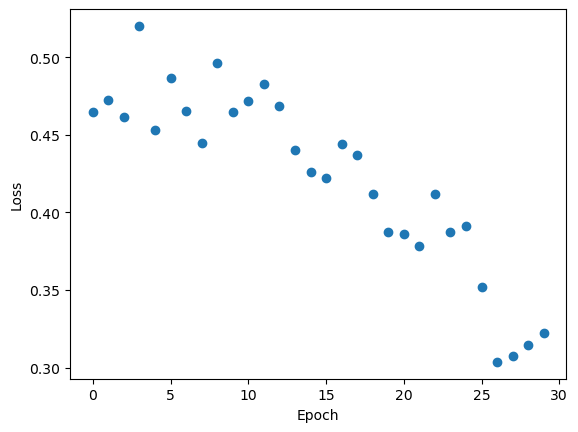

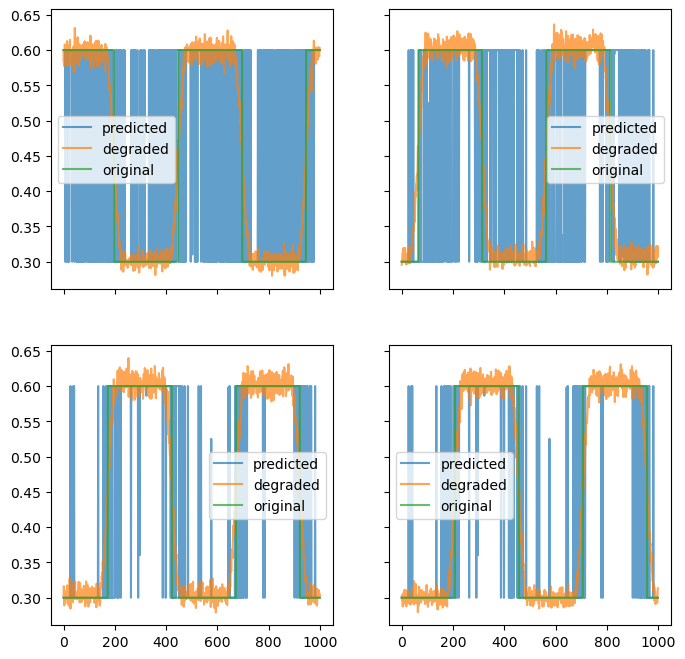

In [56]:
X, y, X_scalers, y_scalers = generate_test_data(amount = 1000, noise_scale = 5000, blur_std = 61, kernel_size=20, vary_x_offset=True)
test_model(X = X, y = y, hidden_size=256, epochs = 30, lr = 0.05, seed_data=42, seed_model=42, X_scalers = X_scalers, y_scalers = y_scalers)

- This example doesn't work
- loss vs epoch is noisy
- considered decreasing `lr`


Data preppared
losses
Epoch 49, Loss: 0.0021088530775159597
Model trained
Done!


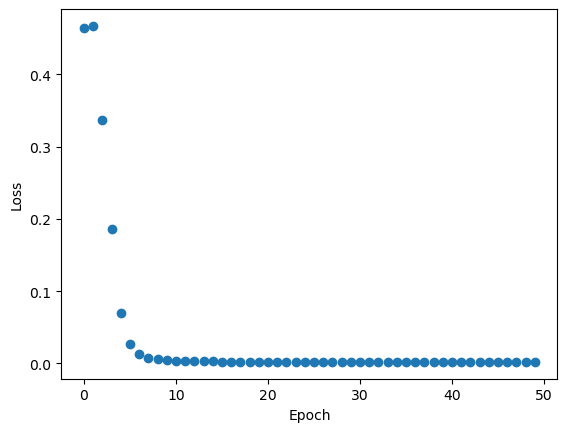

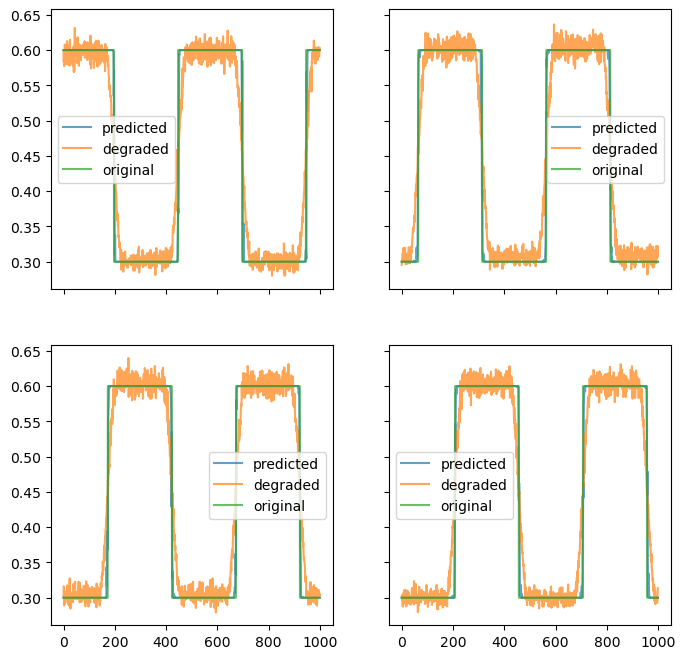

In [57]:
test_model(X = X, y = y, hidden_size=256, epochs = 50, lr = 0.005, X_scalers = X_scalers, y_scalers = y_scalers)

- fixes the problem model fits data well
## modifying x offset, y intercept, period and amplitude


Data preppared
losses
Epoch 199, Loss: 0.0021223679650574923
Model trained
Done!


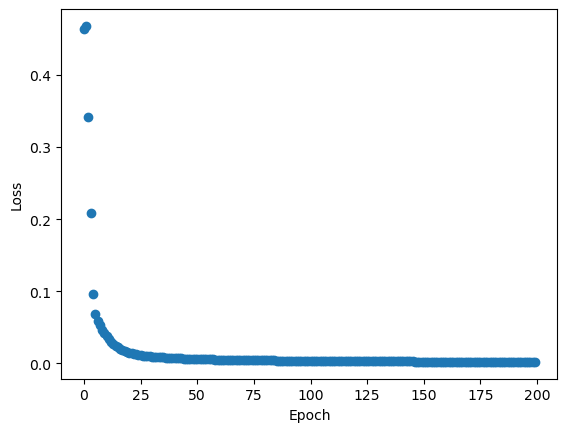

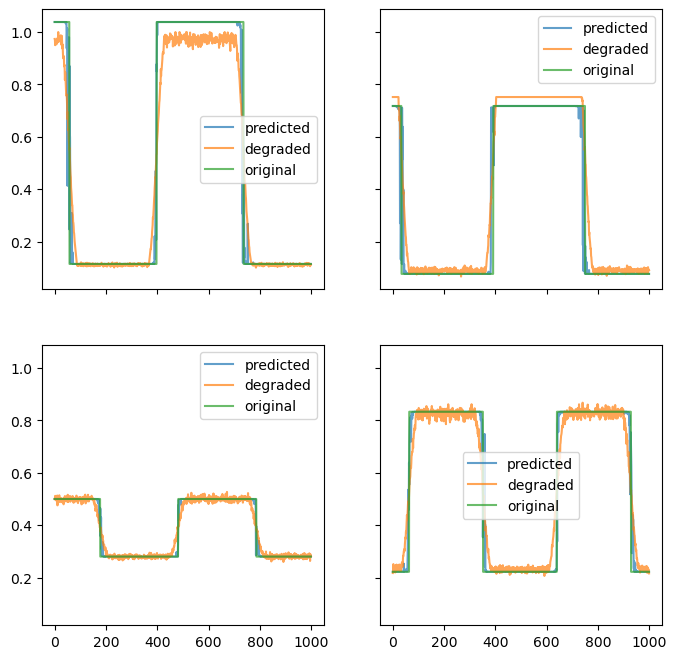

In [63]:
test_model(X=X, y=y, hidden_size=256, epochs = 200, lr = 0.005, seed_model = 42, X_scalers = X_scalers, y_scalers = y_scalers, vary_x_offset=True, vary_period=True, vary_y_intercept=True, vary_amplitude=True,)

## Conclusion
A MLP was sucessfully built which can deconvolve step functions. Future steps include blending this with the richardson lucy algorithm and then testing this on a broader range of functions. Prehaps building this code into a class would be more managable.